In [50]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential,model_from_json
from tensorflow.python.keras.layers import Dense, Activation,Dropout
from tensorflow.python.keras.layers import LSTM , Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import LambdaCallback, ModelCheckpoint
import random
import sys
import io
import re

In [45]:
#print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
filename = "../data/biographie_df.csv"

In [46]:
# Read in only the two columns we need 
df_biographie = pd.read_csv(filename, encoding="utf-8", sep=";", usecols = ['name', 'biographie'])
# df_biographie = pd.read_csv(filename, encoding="utf-8", sep=";")
# We don't want bots :) 
df_biographie.head()

,name,biographie
0,Eminem,"Marshall Bruce Mathers III (born October 17, 1..."
1,Lady Gaga,Stefani Joanne Angelina Germanotta ( STEF-ən-e...
2,Justin Bieber,"Justin Drew Bieber (; born March 1, 1994) is a..."
3,Lil Wayne,"Dwayne Michael Carter Jr. (born September 27, ..."
4,Miley Cyrus,"Miley Ray Hemsworth (née Cyrus, born Destiny H..."


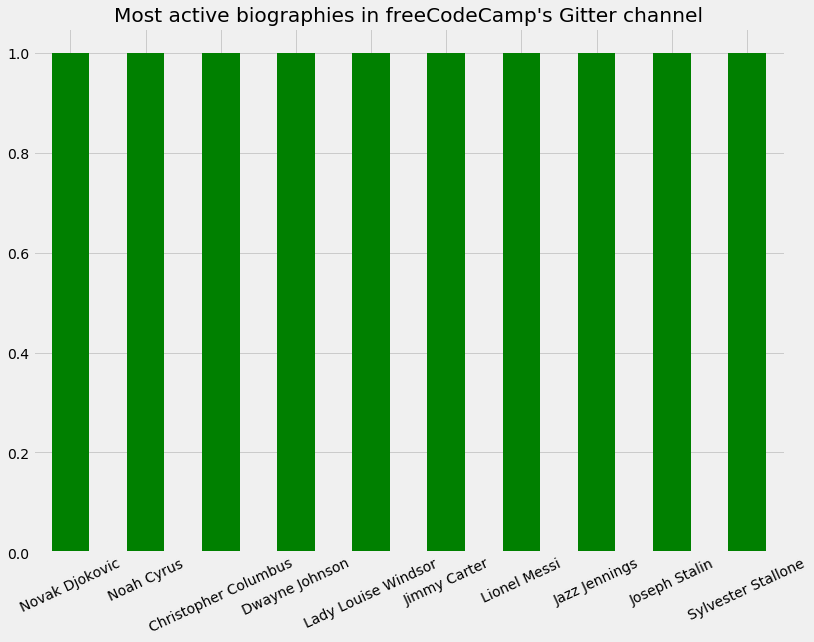

In [47]:
plt.style.use('fivethirtyeight')
f, g = plt.subplots(figsize=(12, 9))
df_biographie['name'].value_counts().head(10).plot.bar(color="green")
g.set_xticklabels(g.get_xticklabels(), rotation=25)
plt.title("Most active biographies in freeCodeCamp's Gitter channel")
plt.show(g)

In [48]:
df_biographie[df_biographie['name'] == "Lionel Messi"].biographie.head(20)

61    Lionel Andrés Messi Cuccittini (Spanish pronun...
Name: biographie, dtype: object

In [51]:
df_biographie['biographie'] = df_biographie['biographie'].apply(lambda x: clean_data(x))

In [52]:
biographie = df_biographie['biographie'][61]

n_messages = len(biographie)
n_chars = len(' '.join(map(str, biographie)))

print("55a7c9e08a7b72f55c3f991e accounts for %d messages" % n_messages)
print("Their messages add up to %d characters" % n_chars)

55a7c9e08a7b72f55c3f991e accounts for 106103 messages
Their messages add up to 212205 characters


In [53]:
sample_size = int(len(biographie) * 0.2)

biographie = biographie[:sample_size]
biographie = ''.join(map(str, biographie)).lower()

biographie[:100] # Show first 100 characters

'lionel andrés messi cuccittini ; born 24 june 1987) is an argentine professional footballer who play'

In [54]:
chars = sorted(list(set(biographie)))
print('Count of unique characters (i.e., features):', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Count of unique characters (i.e., features): 57


In [55]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(biographie) - maxlen, step):
    sentences.append(biographie[i: i + maxlen])
    next_chars.append(biographie[i + maxlen])
print('Number of sequences:', len(sentences), "\n")

print(sentences[:10], "\n")
print(next_chars[:10])

Number of sequences: 7060 

['lionel andrés messi cuccittini ; born 24', 'nel andrés messi cuccittini ; born 24 ju', ' andrés messi cuccittini ; born 24 june ', 'drés messi cuccittini ; born 24 june 198', 's messi cuccittini ; born 24 june 1987) ', 'essi cuccittini ; born 24 june 1987) is ', 'i cuccittini ; born 24 june 1987) is an ', 'uccittini ; born 24 june 1987) is an arg', 'ittini ; born 24 june 1987) is an argent', 'ini ; born 24 june 1987) is an argentine'] 

[' ', 'n', '1', '7', 'i', 'a', 'a', 'e', 'i', ' ']


In [56]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [57]:
model = Sequential()
#model.add(Embedding(len(y), 10, input_length=len(x)))
model.add(LSTM(128, input_shape=(maxlen, len(chars)),return_sequences=True))
model.add(LSTM(128))
model.add(Dense(len(chars)))
model.add(Dropout(0.2))
model.add(Activation('softmax'))

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 40, 128)           95232     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 57)                7353      
_________________________________________________________________
dropout_1 (Dropout)          (None, 57)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 57)                0         
Total params: 234,169
Trainable params: 234,169
Non-trainable params: 0
_________________________________________________________________


In [59]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [60]:
def clean_data(data):
  data = str(data)
  return re.sub(r'\(.*?\)', '', data)

In [61]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [62]:
def on_epoch_end(epoch, logs):
    # Function invoked for specified epochs. Prints generated text.
    # Using epoch+1 to be consistent with the training epochs printed by Keras
    if epoch+1 == 1 or epoch+1 == 15:
        print()
        print('----- Generating text after Epoch: %d' % epoch)

        start_index = random.randint(0, len(biographie) - maxlen - 1)
        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print('----- diversity:', diversity)

            generated = ''
            sentence = biographie[start_index: start_index + maxlen]
            generated += sentence
            print('----- Generating with seed: "' + sentence + '"')
            sys.stdout.write(generated)

            for i in range(400):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                generated += next_char
                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()
    else:
        print()
        print('----- Not generating text after Epoch: %d' % epoch)

In [63]:
generate_text = LambdaCallback(on_epoch_end=on_epoch_end)

# Training the model and generating predictions

In [64]:
# define the checkpoint
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
# fit model using our gpu
with tf.device('/gpu:0'):
    model.fit(x, y,
              batch_size=128,
              epochs=50,
              verbose=2,
              callbacks=[generate_text, checkpoint])

Epoch 1/50

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "w comparisons with his compatriot diego "
w comparisons with his compatriot diego hn he h  he hn  hn h  ah  hn  ae  he  hn he h  ht he h  hn  hn  he  hn  hn  hn th  hn  en  hn h  the he  hn he  hn he te  he  ee  hne  an he h  hn  hn  hn  he hn  hn  he hn h  hn  he  he he he he  hn  hn he  hn  hn he  he  hn  he  ht hns he hi  hn  hn  he  an  hn th  hn  he  hn h  he h  he  hn  hn  hn  hn  hn  hn  he h  he he ha h  hn  he h  ae  hn  he  hn he  hn hn  hn h  hn  he  he  he  an  en h
----- diversity: 0.5
----- Generating with seed: "w comparisons with his compatriot diego "
w comparisons with his compatriot diego an hl un thn he r fhnl  wnn  nn thc cet h,  ha pnt er hn hn  nne h  oin ,g uis  nn  hid ee hn thn hn  an rr a rbr ha o ih gga encs htre h  hot ne hn hecrre hs  neyeth in  hn  e, he nr rphe hr  hn chni he he hl hn  hn cr ot oet  he.  ong  e0 ai ched ht hn h  ee  atp ho t hl hn t pane hs

In [25]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("weights.hdf5")
print("Loaded model from disk")

Saved model to disk
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loaded model from disk


# Test avec une autre biographie

In [26]:
# evaluate loaded model on test data
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [ ]:
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# load weights
model.load_weights("weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# estimate accuracy on whole dataset using loaded weights
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))